# 4강 머신러닝 기본 개념 - daily mission
- 현재 코드는 다음 강의에서 소개될 베이스라인 모델 2 기반으로 만들어진 코드 입니다.

## mission 1 - 좋은 validation set을 만들어 보자
- 강의 중 소개되어 있는 hold-out validation 방법으로 validation set을 만드는 것이 이번 mission입니다.
- 참신한 아이디어를 통해 validation set을 만들으서 leaderboard score와 비교하여 차이가 작은 validation set을 만들어 봅시다.
- make_lgb_prediction 함수의 make validation 부분을 수정하여 validation set을 만드실 수 있습니다.

make_validation() 함수를 사용하여 validation set을 만들거나 custom 하여 더 좋은 방법으로 validation을 만들어 봅시다!

## mission 2 - validation set을 활용하여 overfit - underfit 상태파악
- 학습을 통해 얻은 train log들을 확인하여 그에 상응하는 대처를 해봅시다.
- 강의 중 나온 LightGBM 모델의 파라미터 값들을 조절하여 overfit - underfit을 해결해봅시다.

model_params을 조절하여 overfit -underfit을 해결합시다.

## Function 정의

- seed_everything() : seed 고정 함수
- generate_label() : label 생성 함수
- print_score() : 평가지표 출력 함수
- feature_preprocessing() : 데이터 전처리 함수(label encoding, 결측치 처리)
- feature_engineering1() : 피처 엔지니어링 함수
- make_lgb_prediction() : LightGBM train/predict 함수
- make_validation() : hold-out validation set을 만드는 함수
- plot_feature_importances() : LightGBM 피처 중요도 플롯 함수

## Library Import

In [65]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

## Fix Seed 함수 정의

In [66]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

## 레이블 생성 함수 정의

- 레이블 생성 함수는 연월을 인자로 받아서 고객 아이디별로 총 구매액이 인자로 받는 구매액 임계값을 넘는지 여부를 바이너리 레이블로 생성하는 함수

In [67]:
TOTAL_THRES = 300

'''
    입력인자로 받는 year_month에 대해 고객 ID별로 총 구매액이
    구매액 임계값을 넘는지 여부의 binary label을 생성하는 함수
'''
def generate_label(df, year_month, total_thres=TOTAL_THRES, print_log=False):
    df = df.copy()
    
    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month']<year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month']==year_month]
    
    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = year_month
    
    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    
    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')
    
    return label

## 평가지표 출력 함수 정의

In [68]:
def print_score(label, pred, prob_thres=0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

## 데이터 전처리 함수 정의
- 범주형 변수 레이블 인코딩
- 결측치 중위값으로 채움

In [69]:
def feature_preprocessing(train, test, features, do_imputing=True):
    x_tr = train.copy()
    x_te = test.copy()
    
    # 범주형 피처 이름을 저장할 변수
    cate_cols = []

    # 레이블 인코딩
    for f in features:
        if x_tr[f].dtype.name == 'object': # 데이터 타입이 object(str)이면 레이블 인코딩
            cate_cols.append(f)
            le = LabelEncoder()
            # train + test 데이터를 합쳐서 레이블 인코딩 함수에 fit
            le.fit(list(x_tr[f].values) + list(x_te[f].values))
            
            # train 데이터 레이블 인코딩 변환 수행
            x_tr[f] = le.transform(list(x_tr[f].values))
            
            # test 데이터 레이블 인코딩 변환 수행
            x_te[f] = le.transform(list(x_te[f].values))

    print('categorical feature:', cate_cols)

    if do_imputing:
        # 중위값으로 결측치 채우기
        imputer = SimpleImputer(strategy='median')

        x_tr[features] = imputer.fit_transform(x_tr[features])
        x_te[features] = imputer.transform(x_te[features])
    
    return x_tr, x_te

## 피처 엔지니어링 함수 정의
- Pandas groupby aggregation 함수를 사용한 피처 엔지니어링

In [70]:
def feature_engineering1(df, year_month):
    df = df.copy()
    
    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')
    
    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]
    
    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]
    
    # group by aggregation 함수 선언
    agg_func = ['mean','max','min','sum','count','std','skew']
    all_train_data = pd.DataFrame()
    
    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train.loc[train['order_date'] < tr_ym].groupby(['customer_id']).agg(agg_func)

        # 멀티 레벨 컬럼을 사용하기 쉽게 1 레벨 컬럼명으로 변경
        new_cols = []
        for col in train_agg.columns.levels[0]:
            for stat in train_agg.columns.levels[1]:
                new_cols.append(f'{col}-{stat}')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        train_agg['year_month'] = tr_ym
        
        all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test_agg = test.groupby(['customer_id']).agg(agg_func)
    test_agg.columns = new_cols
    
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')

    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)
    
    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)
    
    return x_tr, x_te, all_train_data['label'], features

## LightGBM train/predict 함수 정의

In [71]:
def percentile_slice(df, column, size):
    '''
    numaric type column을 이용하여 stratified option을 사용하기 위해서 
    해당 column의 분위수 기반으로 새롭게 변수를 하나 만들어 냅니다.
    
    df : pandas dataframe
    column : numaric type column name
    size : percent size
    
    '''

    # np.percentile은 하나의 column을 기준으로 분위수별 값들을 반환해줍니다.
    # 아래 예제는 0분위수 부터 size 만큼 등차로 증가하여 100분위수 까지의 값을 반환합니다.
    th = np.percentile(df[column].values, [x for x in range(0, 101, size)])
    temp_df = df.copy()
    temp_df[column + '_p'] = -1
    for i in range(100 // size):
        # print(i)
        # print(f'{th[i]} - {th[i + 1]}')
        temp_df.loc[(temp_df[column] >= th[i]) & (temp_df[column] <= th[i + 1]), column + '_p'] = i
    return temp_df[column + '_p'].values

def make_validation(train, y, split_type):
    if split_type == 'random':
        # random train validation split
        train_x, valid_x, train_y, valid_y = train_test_split(train, y, shuffle=True, test_size=0.2, random_state=42)
    elif split_type == 'stratify':
        # Stratified train validation split 
        stratify_val = percentile_slice(train, 'total-count', 10)
        train_x, valid_x, train_y, valid_y = train_test_split(train, y, stratify=stratify_val, shuffle=True, test_size=0.2, random_state=42)

    return train_x, valid_x, train_y, valid_y

In [72]:
def make_lgb_prediction(train_x, valid_x, train_y, valid_y, test, features, categorical_features='auto', model_params=None):
    x_train = train_x[features]
    x_valid = valid_x[features]
    x_test = test[features]

    
    print(x_train.shape, x_valid.shape, x_test.shape)

    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # LightGBM 데이터셋 선언
    dtrain = lgb.Dataset(x_train, label=train_y)
    dvalid = lgb.Dataset(x_valid, label=valid_y)

    # LightGBM 모델 훈련
    clf = lgb.train(
        model_params,
        dtrain,
        valid_sets=[dtrain, dvalid],
        categorical_feature=categorical_features,
        verbose_eval=10
    )
    
    # 테스트 데이터 예측
    test_preds = clf.predict(x_test)

    # 피처 중요도 저장
    fi['importance'] = clf.feature_importance()
    
    return test_preds, fi

## LightGBM 피처 중요도 플롯 함수 정의

In [73]:
def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized', 
                            x='feature', color=color, 
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()
    
    return df

## Train 데이터 읽기
- 9개의 feature를 가진 780502개의 train data

In [74]:
data = pd.read_csv("../input/train.csv", parse_dates=["order_date"])
print(data.shape) # data shape 확인
data.head()

(780502, 9)


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


## Pandas info() 함수로 데이터 타입 및 null 체크

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780502 non-null  object        
 1   product_id   780502 non-null  object        
 2   description  780502 non-null  object        
 3   quantity     780502 non-null  int64         
 4   order_date   780502 non-null  datetime64[ns]
 5   price        780502 non-null  float64       
 6   customer_id  780502 non-null  int64         
 7   country      780502 non-null  object        
 8   total        780502 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 53.6+ MB


## Pandas isna(), sum() 함수로 null 데이터 개수 체크

In [76]:
data.isna().sum()

order_id       0
product_id     0
description    0
quantity       0
order_date     0
price          0
customer_id    0
country        0
total          0
dtype: int64

## Pandas describe() 함수에 include='all' 인자 설정으로 수치형, 범주형 데이터 기본 통계량 확인

In [77]:
data.describe(include='all')

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
count,780502,780502,780502,780502.000000,780502,780502.000000,780502.000000,780502,780502.000000
unique,43955,4645,5297,NaN,40615,NaN,NaN,41,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,NaN,United Kingdom,NaN
freq,542,5096,5096,NaN,543,NaN,NaN,700317,NaN
first,NaN,NaN,NaN,NaN,2009-12-01 07:45:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-11-30 17:42:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.623307,NaN,6.140931,15313.393466,NaN,33.715373
std,NaN,NaN,NaN,143.906302,NaN,119.042266,1695.765797,NaN,274.207403
min,NaN,NaN,NaN,-74215.000000,NaN,0.000000,12346.000000,NaN,-127352.940000
25%,NaN,NaN,NaN,2.000000,NaN,2.062500,13963.000000,NaN,7.260000


## 2011년 11월 Label 데이터 생성

In [78]:
label_2011_11 = generate_label(data, '2011-11')['label']

## Label 데이터 분포 플롯

0    4534
1    1188
Name: label, dtype: int64

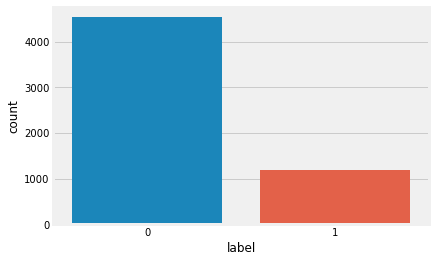

In [79]:
sns.countplot(label_2011_11);
label_2011_11.value_counts()

## LightGBM Hyperparameter 선언

In [80]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.8, # 피처 샘플링 비율
    'bagging_fraction': 0.8, # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 100, # 트리 개수
    'seed': SEED,
    'verbose': -1,
    'n_jobs': -1,    
}

## 2011년 11월 베이스라인 모델 예측
- Validation 성능 측정

In [81]:
train, test, y, features = feature_engineering1(data, '2011-11')
train_x, valid_x, train_y, valid_y = make_validation(train, y, 'random')
test_preds_2011_11, fi = make_lgb_prediction(train_x, valid_x, train_y, valid_y, test, features, model_params=model_params)
print_score(label_2011_11, test_preds_2011_11)

categorical feature: []
x_tr.shape (5501, 24) , x_te.shape (5722, 24)
(4400, 21) (1101, 21) (5722, 21)
[10]	training's auc: 0.867052	valid_1's auc: 0.736543
[20]	training's auc: 0.900682	valid_1's auc: 0.736805
[30]	training's auc: 0.934203	valid_1's auc: 0.733396
[40]	training's auc: 0.958199	valid_1's auc: 0.730833
[50]	training's auc: 0.97332	valid_1's auc: 0.730246
[60]	training's auc: 0.983715	valid_1's auc: 0.728088
[70]	training's auc: 0.990695	valid_1's auc: 0.724147
[80]	training's auc: 0.994444	valid_1's auc: 0.725511
[90]	training's auc: 0.996768	valid_1's auc: 0.723393
[100]	training's auc: 0.998299	valid_1's auc: 0.722271
Precision: 0.63982
Recall: 0.24074
F1 Score: 0.34985
ROC AUC Score: 0.76180


## 2011년 11월 베이스라인 모델 예측 데이터 분포

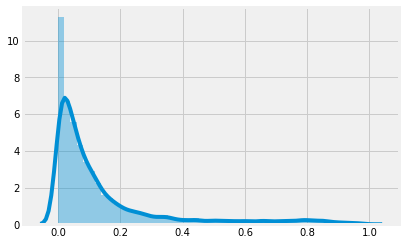

In [82]:
sns.distplot(test_preds_2011_11)
plt.show()

## 2011년 12월 베이스라인 모델 예측
- 테스트 데이터 제출

In [83]:
train, test, y, features = feature_engineering1(data, '2011-12')

categorical feature: []
x_tr.shape (5722, 24) , x_te.shape (5914, 24)


## Stratify option value 선정
- 유저가 기간 내에 몇번 거래했냐(total-count)에 따라서 차이가 보일 것으로 예상된다.
- 그럼 train과 test의 차이는 어떨까?? 

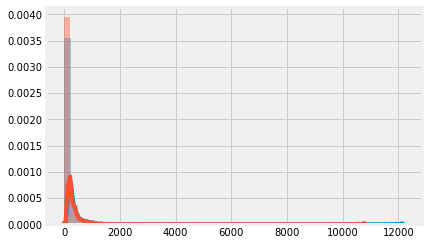

In [87]:
sns.distplot(test['total-count'].values)
sns.distplot(train['total-count'].values)

## Random split
- 아무런 기준 없이 split을 하게 된다면??

In [88]:
train_x, valid_x, train_y, valid_y = make_validation(train, y, 'random')

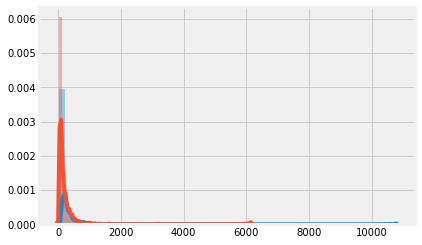

In [89]:
sns.distplot(train_x['total-count'].values)
sns.distplot(valid_x['total-count'].values)

- train과 test차이보다 더 극심한 차이를 보인다.

In [90]:
test_preds, fi = make_lgb_prediction(train_x, valid_x, train_y, valid_y, test, features, model_params=model_params)

(4577, 21) (1145, 21) (5914, 21)
[10]	training's auc: 0.864191	valid_1's auc: 0.756111
[20]	training's auc: 0.900328	valid_1's auc: 0.754067
[30]	training's auc: 0.927315	valid_1's auc: 0.753602
[40]	training's auc: 0.948072	valid_1's auc: 0.753167
[50]	training's auc: 0.962437	valid_1's auc: 0.75321
[60]	training's auc: 0.973745	valid_1's auc: 0.74889
[70]	training's auc: 0.981564	valid_1's auc: 0.747489
[80]	training's auc: 0.987637	valid_1's auc: 0.747094
[90]	training's auc: 0.991977	valid_1's auc: 0.745726
[100]	training's auc: 0.995125	valid_1's auc: 0.743773


- overfit이 심해보인다.

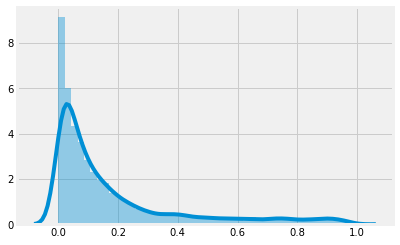

In [91]:
sns.distplot(test_preds)
plt.show()

## stratify split
- 위에서 생각한 validation 전략을 이용하여 실행해보기

In [94]:
train_x, valid_x, train_y, valid_y = make_validation(train, y, 'stratify')

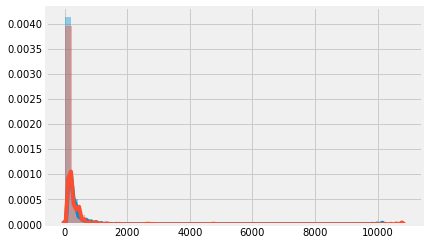

In [95]:
sns.distplot(train_x['total-count'].values)
sns.distplot(valid_x['total-count'].values)

- random으로 split했을 때보다 더 차이가 작다.

In [96]:
test_preds, fi = make_lgb_prediction(train_x, valid_x, train_y, valid_y, test, features, model_params=model_params)

(4577, 21) (1145, 21) (5914, 21)
[10]	training's auc: 0.866978	valid_1's auc: 0.760704
[20]	training's auc: 0.898925	valid_1's auc: 0.758347
[30]	training's auc: 0.922374	valid_1's auc: 0.753906
[40]	training's auc: 0.945694	valid_1's auc: 0.755212
[50]	training's auc: 0.960723	valid_1's auc: 0.748131
[60]	training's auc: 0.972255	valid_1's auc: 0.745354
[70]	training's auc: 0.980643	valid_1's auc: 0.744285
[80]	training's auc: 0.987493	valid_1's auc: 0.740323
[90]	training's auc: 0.991975	valid_1's auc: 0.738068
[100]	training's auc: 0.994713	valid_1's auc: 0.735269


- 하지만 마찬가지로 overfit이 심해보인다.

## 2011년 12월 베이스라인 모델 예측 데이터 분포

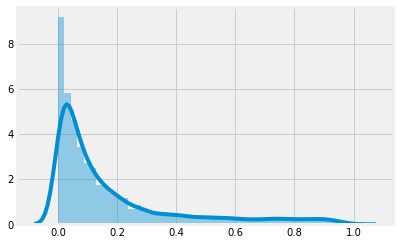

In [97]:
sns.distplot(test_preds)
plt.show()

## 피처 중요도 플롯

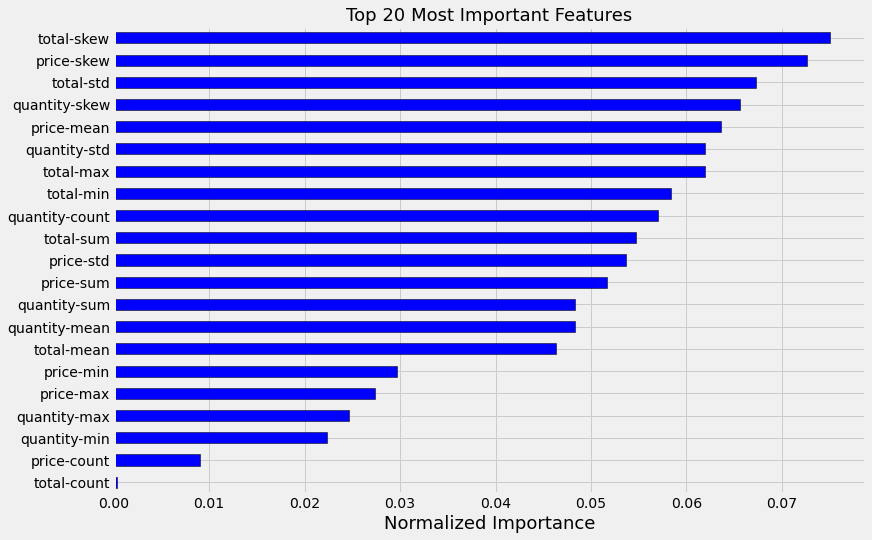

In [46]:
fi = plot_feature_importances(fi)

## make submit file

In [103]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['probability'] = test_preds
output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)
sub.to_csv(os.path.join(output_dir, 'output.csv'), index=False)